In [2]:
import pandas as pd
import numpy as np
import altair as alt
from scipy.stats import f_oneway, bootstrap
import matplotlib as plt
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('human_evaluation_sample - human_evaluation_sample.csv')

In [4]:
df.head()

,assigned_to,title,published,url,video_id,channel_id,full_transcript_length,baseline_summary,rag_summary,human_summary,rag_flan_t5_lg,rag_flan_t5_after_gemini_2.5flash,quality_of_baseline,quality_of_rag,quality_of_human,quality_of_rag_flan_t5_lg,quality_rag_flan_t5_after_gemini_2.5flash,relevance_of_baseline,relevance_of_rag,relevance_of_human,relevance_of_rag_flan_t5_lg,relevance_of_rag_flan_t5_after_gemini_2.5flash,informative_of_baseline,informative_of_rag,informative_of_human,informative_of_rag_flan_t5_lg,informative_of_rag_flan_t5_after_gemini_2.5flash
0,Yingying,What Is Neuralink??! - TDBS 22 April 2017,2017-04-23 11:37:29,What Is Neuralink??! - TDBS 22 April 2017,ToZyCA0uvoI,UCr8O8l5cCX85Oem1d18EezQ,10811,Daniel Burke is standing up and doing this liv...,You are an expert summarizer. Given the follow...,"A vlog video by Daniel Burke, overall its a di...",Daniel Burke is doing a live show on YouTube.,Elon Musk has started a company called Neurali...,1,1,4,3,4,1,1,5,1,5,1,1,4,1,4
1,Yingying,[ML News] Hugging Face course | GAN Theft Auto...,2021-06-24 12:35:09,https://youtu.be/6_q9DbX35kk,6_q9DbX35kk,UCZHmQk67mSJgfCCTn7xBfew,13409,Huggingface releases a course you can now play...,Huggingface releases a course you can now play...,"A ML News video that discusses Hugginf Face, h...",Huggingface the famous NLP startup releases a ...,I'm a big fan of this show. It's a lot of fun....,3,2,5,4,3,2,2,5,3,2,2,2,5,2,2
2,Yingying,I TRAINED AN AI TO SOLVE 2+2 (w/ Live Coding),2020-08-06 16:30:14,https://youtu.be/udS2OPohs_s,udS2OPohs_s,UCZHmQk67mSJgfCCTn7xBfew,9454,Today we're going to build an AI that's going ...,You are an expert summarizer. Given the follow...,An implementation of someone uses Generative ...,The CUDA-based AI model we're going to build i...,We're going to build an AI that's going to ans...,2,1,4,3,2,4,1,5,3,4,2,1,3,3,3
3,Yingying,Code with me (live): How to make your first Ka...,2018-12-02 5:03:43,https://youtu.be/f1y9wDDxWnA,f1y9wDDxWnA,UCr8O8l5cCX85Oem1d18EezQ,104808,Kashuk is a machine learning engineer at the U...,You are an expert summarizer. Given the follow...,A livestream video where the creator walks thr...,The Daniel Burke Show is live on YouTube.,Kaggle: Titanic Machine Learning from Disaster...,4,1,5,3,1,3,1,5,1,1,4,1,3,1,1
4,Yingying,Loading in your own data - Deep Learning basic...,2018-08-18 13:50:58,https://youtu.be/j-3vuBynnOE,j-3vuBynnOE,UCfzlCWGWYyIQ0aLC5w48gBQ,16690,"Part two of our deep learning with Python, Ten...",This tutorial is part three of our deep learni...,"A tutorial video on Deep Learning with Python,...","In this tutorial, we're going to be talking ab...",We're going to use matplotlib to show the imag...,4,4,4,3,2,3,3,4,2,3,3,3,5,2,3


In [5]:
df.columns

Index(['assigned_to', 'title', 'published', 'url', 'video_id', 'channel_id',
       'full_transcript_length', 'baseline_summary', 'rag_summary',
       'human_summary', 'rag_flan_t5_lg', 'rag_flan_t5_after_gemini_2.5flash',
       'quality_of_baseline', 'quality_of_rag', 'quality_of_human',
       'quality_of_rag_flan_t5_lg',
       'quality_rag_flan_t5_after_gemini_2.5flash', 'relevance_of_baseline',
       'relevance_of_rag', 'relevance_of_human', 'relevance_of_rag_flan_t5_lg',
       'relevance_of_rag_flan_t5_after_gemini_2.5flash',
       'informative_of_baseline', 'informative_of_rag', 'informative_of_human',
       'informative_of_rag_flan_t5_lg',
       'informative_of_rag_flan_t5_after_gemini_2.5flash'],
      dtype='object')

In [ ]:
mdlNameDic = {
                'quality_of_baseline':'bart-large-cnn'
              , 'quality_of_rag':'RAG (with bart-large-cnn)'
              , 'quality_of_human':'Human'
              ,'quality_of_rag_flan_t5_lg':'RAG (with flan-t5-large)'
              ,'quality_rag_flan_t5_after_gemini_2.5flash': 'RAG (with Knowledge Distillation)'

              ,'relevance_of_baseline':'bart-large-cnn'
              , 'relevance_of_rag':'RAG (with bart-large-cnn)'
              , 'relevance_of_human':'Human'
              ,'relevance_of_rag_flan_t5_lg':'RAG (with flan-t5-large)'
              ,'relevance_of_rag_flan_t5_after_gemini_2.5flash': 'RAG (with Knowledge Distillation)'
              
              ,'informative_of_baseline':'bart-large-cnn'
              , 'informative_of_rag':'RAG (with bart-large-cnn)'
              , 'informative_of_human':'Human'
              , 'informative_of_rag_flan_t5_lg':'RAG (with flan-t5-large)'
              ,'informative_of_rag_flan_t5_after_gemini_2.5flash': 'RAG (with Knowledge Distillation)'
              }

In [7]:
quality = pd.DataFrame(df[['quality_of_baseline', 'quality_of_rag', 'quality_of_human','quality_of_rag_flan_t5_lg', 'quality_rag_flan_t5_after_gemini_2.5flash']].mean(), columns=['score'])
quality['model'] = quality.index.to_series().apply(lambda x: mdlNameDic[x])
quality['score_name'] = 'quality'

relevance = pd.DataFrame(df[['relevance_of_baseline', 'relevance_of_rag', 'relevance_of_human','relevance_of_rag_flan_t5_lg','relevance_of_rag_flan_t5_after_gemini_2.5flash']].mean(), columns=['score'])
relevance['model'] = relevance.index.to_series().apply(lambda x:  mdlNameDic[x])
relevance['score_name'] = 'relevance'

informative = pd.DataFrame(df[['informative_of_baseline', 'informative_of_rag', 'informative_of_human', 'informative_of_rag_flan_t5_lg', 'informative_of_rag_flan_t5_after_gemini_2.5flash']].mean(), columns=['score'])
informative['model'] = informative.index.to_series().apply(lambda x:  mdlNameDic[x])
informative['score_name'] = 'informativeness'


display(quality)
display(relevance)
display(informative)

,score,model,score_name
quality_of_baseline,3.000000,bart-large-cnn,quality
quality_of_rag,2.166667,RAG (with bart-large-cnn),quality
quality_of_human,4.300000,Human,quality
quality_of_rag_flan_t5_lg,2.700000,RAG (with flan-t5-large),quality
quality_rag_flan_t5_after_gemini_2.5flash,2.533333,RAG (with Knowledge Distillation),quality


,score,model,score_name
relevance_of_baseline,3.133333,bart-large-cnn,relevance
relevance_of_rag,2.200000,RAG (with bart-large-cnn),relevance
relevance_of_human,4.266667,Human,relevance
relevance_of_rag_flan_t5_lg,2.466667,RAG (with flan-t5-large),relevance
relevance_of_rag_flan_t5_after_gemini_2.5flash,2.633333,RAG (with Knowledge Distillation),relevance


,score,model,score_name
informative_of_baseline,3.033333,bart-large-cnn,informativeness
informative_of_rag,2.166667,RAG (with bart-large-cnn),informativeness
informative_of_human,4.100000,Human,informativeness
informative_of_rag_flan_t5_lg,1.866667,RAG (with flan-t5-large),informativeness
informative_of_rag_flan_t5_after_gemini_2.5flash,2.300000,RAG (with Knowledge Distillation),informativeness


In [8]:
scoreDf = pd.concat([quality, relevance, informative])
scoreDf

,score,model,score_name
quality_of_baseline,3.000000,bart-large-cnn,quality
quality_of_rag,2.166667,RAG (with bart-large-cnn),quality
quality_of_human,4.300000,Human,quality
quality_of_rag_flan_t5_lg,2.700000,RAG (with flan-t5-large),quality
quality_rag_flan_t5_after_gemini_2.5flash,2.533333,RAG (with Knowledge Distillation),quality
relevance_of_baseline,3.133333,bart-large-cnn,relevance
relevance_of_rag,2.200000,RAG (with bart-large-cnn),relevance
relevance_of_human,4.266667,Human,relevance
relevance_of_rag_flan_t5_lg,2.466667,RAG (with flan-t5-large),relevance
relevance_of_rag_flan_t5_after_gemini_2.5flash,2.633333,RAG (with Knowledge Distillation),relevance


- Anova test to test there is a difference between scores (e.g. quality) of at least two groups

In [11]:

samp1 = np.array(df.quality_of_baseline)

samp2 = np.array(df.quality_of_rag)

samp3 = np.array(df.quality_of_human)

samp4 = np.array(df.quality_of_rag_flan_t5_lg)

samp5 = np.array(df['quality_rag_flan_t5_after_gemini_2.5flash'])

F = f_oneway(samp1,samp3,samp3,samp4,samp5, equal_var=False)

print(F.pvalue)

8.294435001559941e-17


- bootstrap confidence intervals

In [12]:
def mean_difference(x, y):
    return np.mean(y) - np.mean(x)

<Axes: >

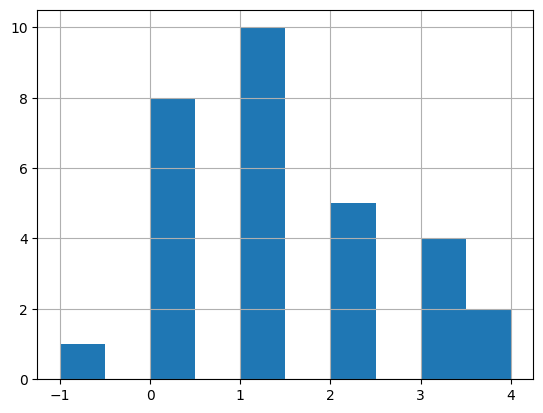

In [13]:
(df['quality_of_human'] - df['quality_of_baseline']).hist()

In [14]:
data1 = df['quality_of_human'].to_numpy()
data2 = df['quality_of_baseline'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.3000
95% confidence interval (percentile method): ConfidenceInterval(low=-1.7666666666666666, high=-0.8666666666666667)
Bootstrap standard error: 0.2327


In [15]:
data1 = df['quality_of_human'].to_numpy()
data2 = df['quality_of_rag'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -2.1333
95% confidence interval (percentile method): ConfidenceInterval(low=-2.6, high=-1.6666666666666665)
Bootstrap standard error: 0.2431


In [16]:
data1 = df['quality_of_human'].to_numpy()
data2 = df['quality_of_human'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: 0.0000
95% confidence interval (percentile method): ConfidenceInterval(low=0.0, high=0.0)
Bootstrap standard error: 0.0000


In [17]:
data1 = df['quality_of_human'].to_numpy()
data2 = df['quality_of_rag_flan_t5_lg'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.6000
95% confidence interval (percentile method): ConfidenceInterval(low=-1.9000000000000004, high=-1.2999999999999994)
Bootstrap standard error: 0.1605


In [20]:
data1 = df['quality_of_human'].to_numpy()
data2 = df['quality_rag_flan_t5_after_gemini_2.5flash'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.7667
95% confidence interval (percentile method): ConfidenceInterval(low=-2.2, high=-1.3666666666666663)
Bootstrap standard error: 0.2148


In [21]:
data1 = df['informative_of_human'].to_numpy()
data2 = df['informative_of_baseline'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.0667
95% confidence interval (percentile method): ConfidenceInterval(low=-1.5333333333333332, high=-0.6333333333333333)
Bootstrap standard error: 0.2312


In [22]:
data1 = df['informative_of_human'].to_numpy()
data2 = df['informative_of_rag'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.9333
95% confidence interval (percentile method): ConfidenceInterval(low=-2.4666666666666663, high=-1.4333333333333331)
Bootstrap standard error: 0.2626


In [23]:
data1 = df['informative_of_human'].to_numpy()
data2 = df['informative_of_human'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: 0.0000
95% confidence interval (percentile method): ConfidenceInterval(low=0.0, high=0.0)
Bootstrap standard error: 0.0000


In [24]:
data1 = df['informative_of_human'].to_numpy()
data2 = df['informative_of_rag_flan_t5_lg'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -2.2333
95% confidence interval (percentile method): ConfidenceInterval(low=-2.6333333333333333, high=-1.8000000000000003)
Bootstrap standard error: 0.2066


In [26]:
data1 = df['informative_of_human'].to_numpy()
data2 = df['informative_of_rag_flan_t5_after_gemini_2.5flash'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.8000
95% confidence interval (percentile method): ConfidenceInterval(low=-2.2, high=-1.4)
Bootstrap standard error: 0.2042


In [27]:
data1 = df['relevance_of_human'].to_numpy()
data2 = df['relevance_of_baseline'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.1333
95% confidence interval (percentile method): ConfidenceInterval(low=-1.6333333333333329, high=-0.6666666666666665)
Bootstrap standard error: 0.2484


In [28]:
data1 = df['relevance_of_human'].to_numpy()
data2 = df['relevance_of_rag'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -2.0667
95% confidence interval (percentile method): ConfidenceInterval(low=-2.666666666666667, high=-1.4333333333333331)
Bootstrap standard error: 0.3149


In [29]:
data1 = df['relevance_of_human'].to_numpy()
data2 = df['relevance_of_human'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: 0.0000
95% confidence interval (percentile method): ConfidenceInterval(low=0.0, high=0.0)
Bootstrap standard error: 0.0000


In [30]:
data1 = df['relevance_of_human'].to_numpy()
data2 = df['relevance_of_rag_flan_t5_lg'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.8000
95% confidence interval (percentile method): ConfidenceInterval(low=-2.2333333333333334, high=-1.333333333333334)
Bootstrap standard error: 0.2313


In [32]:
data1 = df['relevance_of_human'].to_numpy()
data2 = df['relevance_of_rag_flan_t5_after_gemini_2.5flash'].to_numpy()

inData = (data1, data2)

res = bootstrap(inData
                , mean_difference
                , confidence_level=0.95
                , n_resamples=10000,
                paired=True
                , random_state=42
                , method='percentile')

print(f"Original mean difference: {mean_difference(data1, data2):.4f}")
print(f"95% confidence interval (percentile method): {res.confidence_interval}")
print(f"Bootstrap standard error: {res.standard_error:.4f}")

Original mean difference: -1.6333
95% confidence interval (percentile method): ConfidenceInterval(low=-2.0999999999999996, high=-1.1999999999999997)
Bootstrap standard error: 0.2334


In [33]:
scoreDf['font_weight'] = scoreDf.apply(lambda x: 'bold' if ((x['model'] == 'Human') & (x['score_name'] == 'quality')) 
                                                           | ((x['model'] == 'Human') & (x['score_name'] == 'informativeness'))
                                                            | ((x['model'] == 'Human') & (x['score_name'] == 'relevance'))  else 'normal', axis=1)

In [34]:
# Create the grouped bar chart
chart = alt.Chart(scoreDf).mark_bar().encode(
                x=alt.X("score_name:N", title=None, axis=alt.Axis(labelAngle=0)),
                y=alt.Y("score:Q", title="Average Score", axis = alt.Axis(labels=False)),
                xOffset="model:N",
                color=alt.Color("model:N", legend=alt.Legend(title=None))
            ).properties(
                title="Human Evaluation"
                ,width = 400
                ,height = 300

            )

# Text layer
text = chart.encode(
                text=alt.Text('score:Q', format='.1f'), # Format the text as desired
                color=alt.value('black') # Set text color
            ).transform_calculate(
                    fw="datum.font_weight"   # create a calculated field alias
                ).mark_text(
                    align='center',
                    baseline='bottom',
                    dy=-5,  # Nudge text slightly above the bars
                    fontWeight=alt.ExprRef(expr="datum.fw")   # bind font weight dynamically
                )

# & (alt.datum.score_name == 'informativeness')

finalChart = (chart + text)\
                .configure_axis(
                    grid=False
                    ,ticks=False
                )\
                .configure_view(
                    strokeWidth=0
                )

finalChart


alt.LayerChart(...)